In [49]:
## 引入必要的包
import os

from itertools import zip_longest

import torch 
from torch import nn
from torchvision import datasets, transforms
from torchvision.datasets import MNIST, CIFAR10, SVHN
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import numpy as np

from collections import OrderedDict

import matplotlib.pyplot as plt

from art.classifiers import PyTorchClassifier
from art.attacks import ProjectedGradientDescent as PGD
from art.attacks import FastGradientMethod as FGM

from sklearn.decomposition import PCA
from sklearn.neighbors.kde import KernelDensity
from sklearn import tree

In [3]:
## 参数

device = torch.device('cuda:0')
batch_per_log = 100
batch_size = 100
num_workers = 4
param_mnist_A = './data/param_mnist_A'
param_mnist_B = './data/param_mnist_B'
param_cifar_A = './data/param_cifar_A'
param_cifar_B = './data/param_cifar_B'

pgd_mnist_A = './data/adv/pgd_mnist_A.npy'
pgd_mnist_B = './data/adv/pgd_mnist_B.npy'
pgd_cifar_A = './data/adv/pgd_cifar_A.npy'
pgd_cifar_B = './data/adv/pgd_cifar_B.npy'

fgm_mnist_A = './data/adv/fgm_mnist_A.npy'
fgm_mnist_B = './data/adv/fgm_mnist_B.npy'
fgm_cifar_A = './data/adv/fgm_cifar_A.npy'
fgm_cifar_B = './data/adv/fgm_cifar_B.npy'

param_detector_classifier_cifar = './data/param_detector_classifier_cifar'

craft = False

In [4]:
## 定义网络模型MnistNet

class MnistNet(nn.Module):
    def __init__(self, drop=0.5):
        super(MnistNet, self).__init__()

        self.num_channels = 1
        self.num_labels = 10

        activ = nn.ReLU(True)

        self.feature_extractor = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(self.num_channels, 32, 3)),
            ('relu1', activ),
            ('conv2', nn.Conv2d(32, 32, 3)),
            ('relu2', activ),
            ('maxpool1', nn.MaxPool2d(2, 2)),
            ('conv3', nn.Conv2d(32, 64, 3)),
            ('relu3', activ),
            ('conv4', nn.Conv2d(64, 64, 3)),
            ('relu4', activ),
            ('maxpool2', nn.MaxPool2d(2, 2)),
        ]))

        self.classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(64 * 4 * 4, 200)),
            ('relu1', activ),
            ('drop', nn.Dropout(drop)),
            ('fc2', nn.Linear(200, 200)),
            ('relu2', activ),
            ('fc3', nn.Linear(200, self.num_labels)),
        ]))

        for m in self.modules():
            if isinstance(m, (nn.Conv2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        nn.init.constant_(self.classifier.fc3.weight, 0)
        nn.init.constant_(self.classifier.fc3.bias, 0)
    def forward(self, input):
        features = self.feature_extractor(input)
        logits = self.classifier(features.view(-1, 64 * 4 * 4))
        return logits

In [5]:
##定义模型 CiarNet
class SmallCNN(nn.Module):
    def __init__(self, drop=0.5):
        super(SmallCNN, self).__init__()

        self.num_channels = 3
        self.num_labels = 10

        activ = nn.ReLU(True)

        self.feature_extractor = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(self.num_channels, 64, 3, padding = 1)),
            ('bn1', nn.BatchNorm2d(64)),
            ('relu1', activ),
            ('conv2', nn.Conv2d(64, 64, 3, padding=1)),
            ('bn2', nn.BatchNorm2d(64)),
            ('relu2', activ),
            ('maxpool1', nn.MaxPool2d(2)),           
            ('conv3', nn.Conv2d(64, 128, 3, padding=1)),
            ('bn3', nn.BatchNorm2d(128)),
            ('relu3', activ),
            ('conv4', nn.Conv2d(128, 128, 3, padding=1)),
            ('bn4', nn.BatchNorm2d(128)),
            ('relu4', activ),
            ('maxpool2', nn.MaxPool2d(2)),
            ('conv5', nn.Conv2d(128, 196, 3, padding=1)),
            ('bn5', nn.BatchNorm2d(196)),
            ('relu5', activ),
            ('conv6', nn.Conv2d(196, 196, 3, padding=1)),
            ('bn6', nn.BatchNorm2d(196)),
            ('relu6', activ),
            ('maxpool3', nn.MaxPool2d(2)),
        ]))

        self.classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(196 * 4 * 4, 256)),
            ('bn1', nn.BatchNorm1d(256)),
            ('relu1', activ),
            ('fc3', nn.Linear(256, self.num_labels)),
            ]))
        for m in self.modules():
                if isinstance(m, (nn.Conv2d)):
                    nn.init.kaiming_normal_(m.weight)
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
            # nn.init.constant_(self.classifier.fc1.weight, 0)
            # nn.init.constant_(self.classifier.fc1.bias, 0)
        nn.init.constant_(self.classifier.fc3.weight, 0)
        nn.init.constant_(self.classifier.fc3.bias, 0)


        
    def forward(self, input):
        features = self.feature_extractor(input)
        #print(features.size())
        logits = self.classifier(features.view(-1, 196 * 4 * 4))
        return logits

In [6]:
## 训练模型的方法
def acc(model, dataloader, device=torch.device('cuda:0')):
    cnt = 0
    correct = 0
    model = model.to(device)
    for batch in dataloader:
        image = batch[0].to(device)
        label = batch[1].to(device)
        pred = model(image)
        correct += np.sum(label.cpu().numpy() == pred.max(1)[1].cpu().numpy())
        cnt += dataloader.batch_size
    return (correct * 100 / cnt)
    

def train(model, dataloader, file_path ,lr=1e-1, epoch=100, decay=[40, 80], device = torch.device('cuda:0')):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    print("Begin with learning rate %f" % lr)
    loss_fn = nn.CrossEntropyLoss()
    for e in range(epoch):
        if e in decay:
            for param_group in opt.param_groups:
                param_group['lr'] /= 10
            print("Learning rate decay into %f" % opt.param_groups[0]['lr'])
        total_loss = 0
        for batch in dataloader:
            image = batch[0].to(device)
            label = batch[1].to(device)
            pred = model(image)
            loss = loss_fn(pred, label)
            total_loss += loss.item()
            opt.zero_grad()
            loss.backward()
            opt.step()
        print("Epoch %d , loss %f" %(e, total_loss / len(dataloader.dataset)))
        torch.save(model.state_dict(), file_path+'_checkpoint')
        
    torch.save(model.state_dict(), file_path)

In [7]:
##初始化数据集和model
dataset_mnist_A = MNIST(root='./data/', train=True, transform=transforms.ToTensor())
dataset_mnist_B = MNIST(root='./data/', train=False, transform=transforms.ToTensor())
dataloader_mnist_A = DataLoader(dataset_mnist_A, batch_size=batch_size, num_workers=num_workers)
dataloader_mnist_B = DataLoader(dataset_mnist_B, batch_size=batch_size, num_workers=num_workers)
model_mnist_A = MnistNet()
model_mnist_B = MnistNet()
model_mnist_A.train()
model_mnist_B.train()

MnistNet(
  (feature_extractor): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU(inplace)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU(inplace)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu3): ReLU(inplace)
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu4): ReLU(inplace)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (fc1): Linear(in_features=1024, out_features=200, bias=True)
    (relu1): ReLU(inplace)
    (drop): Dropout(p=0.5)
    (fc2): Linear(in_features=200, out_features=200, bias=True)
    (relu2): ReLU(inplace)
    (fc3): Linear(in_features=200, out_features=10, bias=True)
  )
)

In [8]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])


dataset_cifar_A = CIFAR10(root='./data/', train=True, transform=transform)
dataset_cifar_B = CIFAR10(root='./data/', train=False, transform=transform)
dataloader_cifar_A = DataLoader(dataset_cifar_A, batch_size=batch_size, num_workers=num_workers)
dataloader_cifar_B = DataLoader(dataset_cifar_B, batch_size=batch_size, num_workers=num_workers)

model_cifar_A = SmallCNN()
model_cifar_B = SmallCNN()

model_cifar_A.train()
model_cifar_B.train()

SmallCNN(
  (feature_extractor): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace)
    (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU(inplace)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
##训练模型
if os.path.exists(param_mnist_A):
    print("Loading param %s from saved" % param_mnist_A)
    model_mnist_A.load_state_dict(torch.load(param_mnist_A))
else:
    print('Begin to train %s' %param_mnist_A)
    train(model_mnist_A, dataloader_mnist_A, param_mnist_A, lr = 1e-3, epoch=50, decay=[25])
    
if os.path.exists(param_mnist_B):
    print("Loading param %s from saved"% param_mnist_B)
    model_mnist_B.load_state_dict(torch.load(param_mnist_B))
else:
    print("Begin to train %s" % param_mnist_B)
    train(model_mnist_B, dataloader_mnist_B, param_mnist_B, lr = 1e-3, epoch=50, decay=[25])
if os.path.exists(param_cifar_A):
    print("Loading param %s from saved" % param_cifar_A)
    model_cifar_A.load_state_dict(torch.load(param_cifar_A))
else:
    print('Begin to train %s' %param_cifar_A)
    train(model_cifar_A, dataloader_cifar_A, param_cifar_A, lr = 1e-2, epoch=100, decay=[40,80])
    
if os.path.exists(param_cifar_B):
    print("Loading param %s from saved"% param_cifar_B)
    model_cifar_B.load_state_dict(torch.load(param_cifar_B))
else:
    print("Begin to train %s" % param_cifar_B)
    train(model_cifar_B, dataloader_cifar_B, param_cifar_B, lr = 1e-2, epoch=100, decay=[40, 80])

Loading param ./data/param_mnist_A from saved
Loading param ./data/param_mnist_B from saved
Loading param ./data/param_cifar_A from saved
Loading param ./data/param_cifar_B from saved


In [10]:
model_mnist_A.eval()
model_mnist_B.eval()
model_cifar_A.eval()
model_cifar_B.eval()

SmallCNN(
  (feature_extractor): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace)
    (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU(inplace)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
##  评估groundtruthdata 和  surrogatedata 的差距
def gap_evaluate(model_A, model_B,dataloader_A, dataloader_B):
    print('Evaluating the gap ......')
    print('The accuaracy of groundtruth model on the groundtruth data %f'% acc(model_A, dataloader_A, device))
    print('The accuaracy of surrogate model on the surrogate data %f'%acc(model_B, dataloader_B, device))
    print('The accuaracy of groundtruth model on the surrogate data %f'%acc(model_A, dataloader_B, device))
    print('The accuaracy of surrogate model on the groundtruth data %f'% acc(model_B, dataloader_A, device))

In [12]:
print("MNIST")
gap_evaluate(model_mnist_A, model_mnist_B, dataloader_mnist_A, dataloader_mnist_B)
print("CIFAR10")
gap_evaluate(model_cifar_A, model_cifar_B, dataloader_cifar_A, dataloader_cifar_B)

MNIST
Evaluating the gap ......
The accuaracy of groundtruth model on the groundtruth data 100.000000
The accuaracy of surrogate model on the surrogate data 100.000000
The accuaracy of groundtruth model on the surrogate data 99.480000
The accuaracy of surrogate model on the groundtruth data 98.593333
CIFAR10
Evaluating the gap ......
The accuaracy of groundtruth model on the groundtruth data 99.712000
The accuaracy of surrogate model on the surrogate data 99.730000
The accuaracy of groundtruth model on the surrogate data 90.580000
The accuaracy of surrogate model on the groundtruth data 81.374000


In [13]:
## 生成对抗样本
classifier_mnist_A = PyTorchClassifier(model_mnist_A, nn.CrossEntropyLoss(), torch.optim.Adam(model_mnist_A.parameters()),  \
                                       (batch_size,1, 28, 28), 10)
classifier_mnist_B = PyTorchClassifier(model_mnist_B, nn.CrossEntropyLoss(), torch.optim.Adam(model_mnist_B.parameters()), \
                                       (batch_size,1, 28, 28), 10)
classifier_cifar_A = PyTorchClassifier(model_cifar_A, nn.CrossEntropyLoss(), torch.optim.Adam(model_cifar_A.parameters()), \
                                       (batch_size,1, 32, 32), 10)
classifier_cifar_B = PyTorchClassifier(model_cifar_B, nn.CrossEntropyLoss(), torch.optim.Adam(model_cifar_B.parameters()),\
                                       (batch_size,1, 32, 32), 10)

PGD_mnist_A = PGD(classifier_mnist_A, norm=np.inf, eps=0.3, eps_step=0.1, max_iter=40, targeted=False, num_random_init=0, batch_size=batch_size)
FGM_mnist_A = FGM(classifier_mnist_A, norm=np.inf, eps=0.3, eps_step=0.3, targeted=False, num_random_init=0, batch_size=batch_size)

PGD_mnist_B = PGD(classifier_mnist_B, norm=np.inf, eps=0.3, eps_step=0.1, max_iter=40, targeted=False, num_random_init=0, batch_size=batch_size)
FGM_mnist_B = FGM(classifier_mnist_B, norm=np.inf, eps=0.3, eps_step=0.3, targeted=False, num_random_init=0, batch_size=batch_size)

PGD_cifar_A = PGD(classifier_cifar_A,norm=np.inf, eps=0.031, eps_step=0.031/4, max_iter=40, targeted=False, num_random_init=0, batch_size=batch_size)
FGM_cifar_A = FGM(classifier_cifar_A, norm=np.inf, eps=0.031, eps_step=0.031, targeted=False, num_random_init=0, batch_size=batch_size)

PGD_cifar_B = PGD(classifier_cifar_B, norm=np.inf, eps=0.031, eps_step=0.031/4, max_iter=40, targeted=False, num_random_init=0, batch_size=batch_size)
FGM_cifar_B = FGM(classifier_cifar_B, norm=np.inf, eps=0.031, eps_step=0.031, targeted=False, num_random_init=0, batch_size=batch_size)




In [14]:
def craft_adversarial_example(attacker, dataloader, filepath=None):
    Xlst = []
    ylst = []
    cnt = 0
    success = 0
    correct = 0
    for batch in dataloader:
        image = batch[0].numpy()
        label = batch[1].numpy()
        pred = attacker.classifier.predict(image).argmax(axis=1)
        adv = attacker.generate(image)
        pred_adv = attacker.classifier.predict(adv).argmax(axis=1)
        cnt += dataloader.batch_size
        success += np.sum(pred_adv != label)
        correct += np.sum(pred == label)
        Xlst.append(adv[np.where(pred_adv!=label)])
        ylst.append(label[np.where(pred_adv!=label)])
        print('%d / %d' %(cnt, len(dataloader.dataset)), end='\r')
    print("The accuracy on the clean data %f" % (correct * 100 / cnt ))
    print("The accuracy on the adv is %f" % ((cnt - success) * 100 / cnt))
    print("Success rate of the attack is %f" %(success * 100 / cnt))
    if filepath is not None:
        np.save(filepath, np.concatenate(Xlst, axis=0)) 
        np.save(filepath[:-4]+'.label', np.concatenate(ylst, axis=0))
    return

In [15]:
if craft:
    
    craft_adversarial_example(PGD_mnist_A, dataloader_mnist_A,  pgd_mnist_A)
    craft_adversarial_example(FGM_mnist_A, dataloader_mnist_A, fgm_mnist_A)

    craft_adversarial_example(PGD_mnist_B, dataloader_mnist_B,  pgd_mnist_B)
    craft_adversarial_example(FGM_mnist_B, dataloader_mnist_B, fgm_mnist_B)

    craft_adversarial_example(PGD_cifar_A, dataloader_cifar_A, pgd_cifar_A)
    craft_adversarial_example(FGM_cifar_A, dataloader_cifar_A, fgm_cifar_A)

    craft_adversarial_example(PGD_cifar_B, dataloader_cifar_B, pgd_cifar_B)
    craft_adversarial_example(FGM_cifar_B, dataloader_cifar_B, fgm_cifar_B)



In [16]:
class AdvDataset(Dataset):
    def __init__(self, Xfile, yfile):
        self.X = np.load(Xfile)
        self.y = np.load(yfile)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        return (image, label)

In [17]:
acc(model_cifar_B, DataLoader(AdvDataset(pgd_cifar_B, pgd_cifar_B[:-4] + '.label.npy'), num_workers=num_workers, batch_size=batch_size), device)

0.0

In [18]:
acc(model_cifar_B, DataLoader(AdvDataset(fgm_cifar_B, fgm_cifar_B[:-4] + '.label.npy'), num_workers=num_workers, batch_size=batch_size), device)

0.0

In [19]:
acc(model_cifar_A, DataLoader(AdvDataset(pgd_cifar_A, pgd_cifar_A[:-4] + '.label.npy'), num_workers=num_workers, batch_size=batch_size), device)

0.0

In [20]:
acc(model_cifar_A, DataLoader(AdvDataset(fgm_cifar_A, fgm_cifar_A[:-4] + '.label.npy'), num_workers=num_workers, batch_size=batch_size), device)

0.0

In [21]:
acc(model_mnist_B, DataLoader(AdvDataset(pgd_mnist_B, pgd_mnist_B[:-4] + '.label.npy'), num_workers=num_workers, batch_size=batch_size), device)

0.0

In [22]:
acc(model_mnist_B, DataLoader(AdvDataset(fgm_mnist_B, fgm_mnist_B[:-4] + '.label.npy'), num_workers=num_workers, batch_size=batch_size), device)

0.0

In [23]:
acc(model_mnist_A, DataLoader(AdvDataset(pgd_mnist_A, pgd_mnist_A[:-4] + '.label.npy'), num_workers=num_workers, batch_size=batch_size), device)

0.0

In [24]:
acc(model_mnist_A, DataLoader(AdvDataset(fgm_mnist_A, fgm_mnist_A[:-4] + '.label.npy'), num_workers=num_workers, batch_size=batch_size), device)

0.0

In [25]:
detector_classifier_mnist = MnistNet()
detector_classifier_mnist.classifier.fc3 = nn.Linear(200, 2, bias=True)
detector_classifier_mnist.train()
detector_classifier_cifar = SmallCNN()
detector_classifier_cifar.classifier.fc3 = nn.Linear(256, 2)
detector_classifier_cifar.train()

SmallCNN(
  (feature_extractor): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace)
    (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU(inplace)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
def train_detector(model, dataloader_clean, pgd_file, fgm_file, epoch, lr=1e-3, decay=[], device=torch.device('cuda:0')):
    model = model.to(device)
    batch_size = dataloader_clean.batch_size
    n = len(dataloader_clean.dataset)
    loss_fn = nn.CrossEntropyLoss()
    pgd = np.load(pgd_file)
    fgm = np.load(fgm_file)
    adv = torch.tensor(np.concatenate([pgd, fgm], axis=0))
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    print('Begin with Learning rate %f' %lr)
    for e in range(epoch):
        if e in decay:
            for param_group in opt.param_groups:
                param_group['lr'] /= 10
            print("Learning rate decay into %f" % opt.param_groups[0]['lr'])
        total_loss = 0
        cnt = 0
        for i, clean in enumerate(dataloader_clean):
            image = torch.cat([clean[0], adv[(i * batch_size) % n: min((i* batch_size) % n + batch_size,  n)]], dim=0).to(device)
            label = torch.cat([torch.zeros(batch_size), torch.ones(len(image) - batch_size)]).to(device).long()
#             print(image.shape)
#             print(label.shape)
            pred = model(image)
#             print(pred.max(1)[1])
            loss = loss_fn(pred, label)
#             print(loss.item())
            total_loss += loss.item()
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
        print("Epoch %d loss %f" % (e, total_loss))

In [27]:
train_detector(detector_classifier_mnist, dataloader_mnist_B,pgd_mnist_B, fgm_mnist_B, 10, device=device)

Begin with Learning rate 0.001000
Epoch 0 loss 6.153110
Epoch 1 loss 0.000533
Epoch 2 loss 0.000137
Epoch 3 loss 0.000090
Epoch 4 loss 0.000102
Epoch 5 loss 0.000056
Epoch 6 loss 0.000109
Epoch 7 loss 0.000065
Epoch 8 loss 0.000034
Epoch 9 loss 0.000040


In [28]:
train_detector(detector_classifier_cifar, dataloader_cifar_B,  pgd_cifar_B, fgm_cifar_B, 30, device=device,decay=[15, 25])

Begin with Learning rate 0.001000
Epoch 0 loss 30.719531
Epoch 1 loss 6.399493
Epoch 2 loss 2.777339
Epoch 3 loss 2.265008
Epoch 4 loss 1.263271
Epoch 5 loss 0.648414
Epoch 6 loss 0.558166
Epoch 7 loss 1.208184
Epoch 8 loss 0.457944
Epoch 9 loss 0.246271
Epoch 10 loss 1.099340
Epoch 11 loss 0.230009
Epoch 12 loss 0.324518
Epoch 13 loss 0.160090
Epoch 14 loss 0.250855
Learning rate decay into 0.000100
Epoch 15 loss 0.062639
Epoch 16 loss 0.073838
Epoch 17 loss 0.046025
Epoch 18 loss 0.049574
Epoch 19 loss 0.030234
Epoch 20 loss 0.069228
Epoch 21 loss 0.050297
Epoch 22 loss 0.030583
Epoch 23 loss 0.037591
Epoch 24 loss 0.017875
Learning rate decay into 0.000010
Epoch 25 loss 0.011460
Epoch 26 loss 0.020364
Epoch 27 loss 0.014318
Epoch 28 loss 0.019117
Epoch 29 loss 0.022526


In [29]:
detector_classifier_cifar.eval()
detector_classifier_mnist.eval()

MnistNet(
  (feature_extractor): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU(inplace)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU(inplace)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu3): ReLU(inplace)
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu4): ReLU(inplace)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (fc1): Linear(in_features=1024, out_features=200, bias=True)
    (relu1): ReLU(inplace)
    (drop): Dropout(p=0.5)
    (fc2): Linear(in_features=200, out_features=200, bias=True)
    (relu2): ReLU(inplace)
    (fc3): Linear(in_features=200, out_features=2, bias=True)
  )
)

In [30]:
def eval_detector(model, dataloader_clean, pgd_file, fgm_file, device=torch.device('cuda:0')):
    model = model.to(device)
    batch_size = dataloader_clean.batch_size
    n = len(dataloader_clean.dataset)
    
    pgd = np.load(pgd_file)
    fgm = np.load(fgm_file)
    adv = torch.tensor(np.concatenate([pgd, fgm], axis=0))
    first_type_error = 0
    second_type_error = 0
    correct = 0
    cnt = 0
        
    for i, clean in enumerate(dataloader_clean):
        image = torch.cat([clean[0], adv[(i * batch_size) % n: min((i* batch_size) % n + batch_size,  n)]], dim=0).to(device)
        label = torch.cat([torch.zeros(batch_size), torch.ones(len(image) - batch_size)]).numpy()
#             print(image.shape)
#             print(label.shape)
        pred = model(image).max(1)[1].cpu().numpy()
#             print(pred.max(1)[1])
        correct += np.sum(pred == label)
        first_type_error += np.sum(label * (1-pred))
        second_type_error += np.sum((1-label) * pred)
        cnt += len(clean[0])
    print("Accuracy is %f" % (correct * 50 /cnt))
    print("First Type Error is %f " % (first_type_error* 50/cnt))
    print("Second Type Errot is %f" %(second_type_error * 50 / cnt))
    return 
            
        



In [31]:
eval_detector(detector_classifier_cifar, dataloader_cifar_A,  pgd_cifar_A, fgm_cifar_A)

Accuracy is 99.904000
First Type Error is 0.086000 
Second Type Errot is 0.010000


In [32]:
eval_detector(detector_classifier_cifar, dataloader_cifar_B,  pgd_cifar_B, fgm_cifar_B)

Accuracy is 99.980000
First Type Error is 0.000000 
Second Type Errot is 0.020000


In [33]:
eval_detector(detector_classifier_mnist, dataloader_mnist_B,  pgd_mnist_B, fgm_mnist_B)

Accuracy is 100.000000
First Type Error is 0.000000 
Second Type Errot is 0.000000


In [34]:
eval_detector(detector_classifier_cifar, dataloader_cifar_A,  pgd_cifar_A, fgm_cifar_A)

Accuracy is 99.900000
First Type Error is 0.086000 
Second Type Errot is 0.014000


In [35]:
transform_svhn =  transforms.Compose([
    transforms.Grayscale(1),
    transforms.RandomCrop(28),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
dataset_svhn = SVHN(root='./data/', download=True, transform=transform_svhn)
dataloader_svhn = DataLoader(dataset_svhn, num_workers=num_workers, batch_size=batch_size)

Using downloaded and verified file: ./data/train_32x32.mat


In [36]:
acc(model_mnist_A, dataloader_svhn, device=device)

21.46657571623465

In [37]:
## 构建PCA Detector

class PCADetector(object):
    def __init__(self, domain, t, smoother=1e-3):
        self.p = int(domain.size / domain.shape[0])
        self.domain = domain.reshape(-1, self.p)
        self.mean = np.mean(self.domain, axis=0)
        self.cov = np.matmul((self.domain-self.mean).T, (self.domain-self.mean) ) / domain.shape[0]
        self.u, self.s, self.v = np.linalg.svd(self.cov)
        self.smoother = smoother
        self.t = t
        
    def transform(self, image):
        image = image.reshape(-1)-self.mean
        y = np.matmul(image, self.u) /(np.sqrt(self.s) + self.smoother)
        
        return y
        
    def fit(self, adv_files):
        adv = []
        for file in adv_files:
            adv.append(np.load(file))
        adv = np.concatenate(adv, axis=0)
        score =[]
        label = []
        for i in range(len(self.domain)):
            image = self.domain[i]
            y = self.transform(image)
            s = np.var(y[self.t:])
            label.append(0)
            score.append(s)
        for i in range(len(adv)):
            image = adv[i]
            y = self.transform(image)
            s = np.var(y[self.t:])
            label.append(1)
            score.append(s)
        
        self.clf = clf = tree.DecisionTreeClassifier()
        clf.fit(np.array(score).reshape(-1, 1), label)
        
    
    def detect(self, image):
        y = self.transform(image)
        s = np.var(y[self.t:])
        return self.clf.predict(np.array([[s]]))

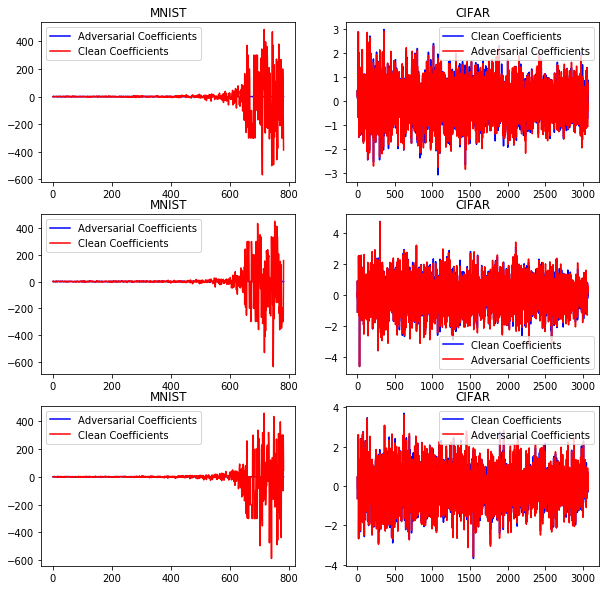

In [38]:
## 对比对抗样本和普通图片的异同
domain_mnist = dataset_mnist_B.data.numpy() / 255.0
domain_cifar = dataset_cifar_B.data / 255.0
pca_mnist = PCADetector(domain_mnist, t=500)
pca_cifar = PCADetector(domain_cifar, smoother=0.1, t=2500)
plt.figure(figsize=(10,10))
for i in range(3):
    idx = np.random.randint(0, 1000)
    image_mnist = domain_mnist[idx]
    image_cifar = domain_cifar[idx].transpose([2,0,1])
    adv_mnist = PGD_mnist_B.generate(image_mnist[np.newaxis, np.newaxis, :, :])
    adv_cifar = PGD_cifar_B.generate(image_cifar[np.newaxis, :, :, :])
    plt.subplot(3,2,1 + i*2)
    plt.plot(pca_mnist.transform(image_mnist), 'b', label='Clean')
    plt.plot(pca_mnist.transform(adv_mnist), 'r', label = "Adversarial")
    plt.title('MNIST')
    plt.legend(['Adversarial Coefficients', 'Clean Coefficients'])
    plt.subplot(3,2, 2+i*2)
    plt.plot(pca_cifar.transform(image_cifar), 'b', label='Clean')
    plt.plot(pca_cifar.transform(adv_cifar), 'r', label = "Adversarial")
    plt.title('CIFAR')
    plt.legend(['Clean Coefficients' , 'Adversarial Coefficients'])
plt.show()

pca_mnist.fit([pgd_mnist_B, fgm_mnist_B])
pca_cifar.fit([pgd_cifar_B, fgm_cifar_B])

In [39]:
##测试效果
def evaluate(pca_detector, clean, adv):
    nc = len(clean)
    na = len(adv)
    clean_label = []
    adv_label = []
    for image in clean:
        clean_label.append(pca_detector.detect(image))
    for image in adv:
        adv_label.append(pca_detector.detect(image))
    clean_label = np.concatenate(clean_label)
    adv_label = np.concatenate(adv_label)
    correct_clean = np.sum(clean_label == np.zeros_like(clean_label))
    correct_adv = np.sum(adv_label == np.ones_like(adv_label))
    print("The accuracy is %f" % ((100 * correct_clean + 100 * correct_adv) / (na + nc)))
    print("The first type error is %f" % (100 * (nc - correct_clean) / (na + nc)))
    print("The second type error is %f" % (100 * (na - correct_adv) / (na + nc)))
    return

In [40]:
evaluate(pca_mnist, dataset_mnist_A.data.numpy()/255.0, np.load(pgd_mnist_A))

The accuracy is 100.000000
The first type error is 0.000000
The second type error is 0.000000


In [41]:
evaluate(pca_cifar, dataset_cifar_A.data/255.0, np.load(pgd_cifar_A))

The accuracy is 99.954924
The first type error is 0.045076
The second type error is 0.000000


In [42]:
## 把数据降低维度之后放入分类器
pca_mnist = PCA(n_components=500)
pca_mnist.fit(dataset_mnist_B.data.numpy().reshape(-1, 784)/255.0)
pca_cifar = PCA(n_components=2000)
pca_cifar = pca_cifar.fit(X = dataset_cifar_B.data.reshape(-1, 3072)/ 255.0)


In [43]:
clean_correct = 0
adv_correct = 0
adv = np.concatenate([np.load(pgd_mnist_A), np.load(fgm_mnist_A)], axis=0)
nc = len(dataloader_mnist_A.dataset)
na = len(adv)
for batch in dataloader_mnist_A:
    image_reduce = pca_mnist.transform(batch[0].numpy().reshape(-1, 784))
    image_recon = torch.tensor(pca_mnist.inverse_transform(image_reduce).reshape(-1, 1, 28, 28)).to(device)
    label_recon = model_mnist_A.to(device).double()(image_recon).max(1)[1]
    label = batch[1].to(device)
    clean_correct += torch.sum(label == label_recon).item()
for i in range(0, len(adv) - batch_size, batch_size):
   
    image_reduce = pca_mnist.transform(adv[i:i+batch_size].reshape(-1, 784))
    image_recon = torch.tensor(pca_mnist.inverse_transform(image_reduce).reshape(-1, 1, 28, 28)).to(device)
    image = torch.tensor(adv[i:i+batch_size]).to(device)
    
    label = model_mnist_A.to(device)(image.double()).max(1)[1]
    label_recon = model_mnist_A.to(device).double()(image_recon).max(1)[1]
    adv_correct += torch.sum(label != label_recon)
print(100 * (clean_correct + adv_correct))
print(100 * (na - adv_correct))
print("Accuracy %f" % (100 * (clean_correct + adv_correct) / (nc + na)))
print("Fisrt type error %f" %(100 * (nc - clean_correct) /  (nc+na)))
print("Fisrt type error %f" %(100 * (na - adv_correct) /  (nc + na)))


tensor(6324100, device='cuda:0')
tensor(10172500, device='cuda:0')
Accuracy 38.000000
Fisrt type error 0.000000
Fisrt type error 61.000000


In [44]:
clean_correct = 0
adv_correct = 0
 
adv = np.concatenate([np.load(pgd_cifar_A), np.load(fgm_cifar_A)], axis=0)
for batch in dataloader_cifar_A:
    image_reduce = pca_cifar.transform(batch[0].numpy().reshape(-1, 3072))
    image_recon = torch.tensor(pca_cifar.inverse_transform(image_reduce).reshape(-1, 3, 32, 32)).to(device)
    label_recon = model_cifar_A.to(device).double()(image_recon).max(1)[1]
    label = batch[1].to(device)
    clean_correct += torch.sum(label == label_recon).item()
for i in range(0, len(adv) - batch_size, batch_size):
    image_reduce = pca_cifar.transform(adv[i:i+batch_size].reshape(-1, 3072))
    image_recon = torch.tensor(pca_cifar.inverse_transform(image_reduce).reshape(-1, 3, 32, 32)).to(device)
    image = torch.tensor(adv[i:i+batch_size]).to(device)
    
    label = model_cifar_A.to(device)(image.double()).max(1)[1]
    label_recon = model_cifar_A.to(device).double()(image_recon).max(1)[1]
    adv_correct += torch.sum(label != label_recon)
    
print("Accuracy %f" % (100 * (clean_correct + adv_correct) / (len(dataloader_mnist_A.dataset) + len(adv))))
print("Fisrt type error %f" %(100 * (len(dataloader_mnist_A.dataset) - clean_correct) /  (len(dataloader_mnist_A.dataset) + len(adv))))
print("Fisrt type error %f" %(100 * (len(adv) - adv_correct) /  (len(dataloader_mnist_A.dataset) + len(adv))))


Accuracy 41.000000
Fisrt type error 14.585439
Fisrt type error 44.000000


In [71]:
class KDEDetector(object):
    def __init__(self, model, dataloader_clean, dataloader_adv, device=torch.device("cuda:0")):
        self.clean = dataloader_clean
        self.adv = dataloader_adv
        self.kde = KernelDensity(kernel='gaussian')
        self.clf = tree.DecisionTreeClassifier()
        self.model = model.to(device)
    
        
    def fit(self):
        logits = []
        y = []
        for batch in self.clean:
            image = batch[0].to(device)
            act = self.model(image)
            logits.append(act.detach().cpu().numpy())
            y.append(np.zeros(image.shape[0]))
            
        for batch in self.adv:
            image = batch[0].to(device)
            act = self.model(image)
            logits.append(act.detach().cpu().numpy())
            y.append(np.ones(image.shape[0]))
        
        logits = np.concatenate(logits, axis=0)
        y = np.concatenate(y, axis=0)
       
        self.kde.fit(logits)
        X = self.kde.score_samples(logits)
        
        self.clf.fit(X.reshape(-1, 1), y)
        
    def detect(self, test):
        logits = []
        y = []
        for batch in  test:
            image = batch[0].to(device)
            act = self.model(image)
            logits.append(act.detach().cpu().numpy())
        logits = np.concatenate(logits, axis=0)
        X = self.kde.score_samples(logits)
        y = self.clf.predict(X.reshape(-1, 1))
        return y

In [93]:
dataset_adv_mnist_B = ConcatDataset([AdvDataset(fgm_mnist_B, fgm_mnist_B[:-4] + '.label.npy'),AdvDataset(pgd_mnist_B, pgd_mnist_B[:-4] + '.label.npy') ])
dataloader_adv_mnist_B = DataLoader(dataset_adv_mnist_B, num_workers=num_workers, batch_size=batch_size)
dataset_adv_mnist_A = ConcatDataset([AdvDataset(fgm_mnist_A, fgm_mnist_A[:-4] + '.label.npy'),AdvDataset(pgd_mnist_A, pgd_mnist_A[:-4] + '.label.npy') ])
dataloader_adv_mnist_A = DataLoader(dataset_adv_mnist_A, num_workers=num_workers, batch_size=batch_size)
kde_mnist = KDEDetector(model_mnist_B,dataloader_mnist_B , dataloader_adv_mnist_B)
kde_mnist.fit()
pred_mnist_A = kde_mnist.detect(dataloader_mnist_A)
pred_mnist_adv_A = kde_mnist.detect(dataloader_adv_mnist_A)
print("Accuracy: %f" % (100 * (np.sum(pred_mnist_A==0) + np.sum(pred_mnist_adv_A==1)) / (len(pred_mnist_A) + len(pred_mnist_adv_A))))
print("First Type Error: %f" % (100 * (np.sum(pred_mnist_A==1)) / (len(pred_mnist_A) + len(pred_mnist_adv_A))))
print("Second Type Error: %f " % (100 * (np.sum(pred_mnist_adv_A==0)) / (len(pred_mnist_A) + len(pred_mnist_adv_A))) )

Accuracy: 66.982893
First Type Error: 32.776451
Second Type Error: 0.240656 


In [98]:
dataset_adv_cifar_B = ConcatDataset([AdvDataset(fgm_cifar_B, fgm_cifar_B[:-4] + '.label.npy'),AdvDataset(pgd_cifar_B, pgd_cifar_B[:-4] + '.label.npy') ])
dataloader_adv_cifar_B = DataLoader(dataset_adv_cifar_B, num_workers=num_workers, batch_size=batch_size)
dataset_adv_cifar_A = ConcatDataset([AdvDataset(fgm_cifar_A, fgm_cifar_A[:-4] + '.label.npy'),AdvDataset(pgd_cifar_A, pgd_cifar_A[:-4] + '.label.npy') ])
dataloader_adv_cifar_A = DataLoader(dataset_adv_cifar_A, num_workers=num_workers, batch_size=batch_size)
kde_cifar = KDEDetector(model_cifar_B,dataloader_cifar_B , dataloader_adv_cifar_B)
kde_cifar.fit()
pred_cifar_A = kde_cifar.detect(dataloader_cifar_A)
pred_cifar_adv_A = kde_cifar.detect(dataloader_adv_cifar_A)
print("Accuracy: %f" % (100 * (np.sum(pred_cifar_A==0) + np.sum(pred_cifar_adv_A==1)) / (len(pred_cifar_A) + len(pred_cifar_adv_A))))
print("First Type Error: %f" % (100 * (np.sum(pred_cifar_A==1)) / (len(pred_cifar_A) + len(pred_cifar_adv_A))))
print("Second Type Error: %f " % (100 * (np.sum(pred_cifar_adv_A==0)) / (len(pred_cifar_A) + len(pred_cifar_adv_A))))

Accuracy: 65.369165
First Type Error: 34.630835
Second Type Error: 0.000000 


104569

In [ ]:
class LIDDetector(object):
    def __init__(self, model, dataloader_clean, dataloader_adv):
        self.model = model
        self.clean = dataloader_clean
        self.adv = dataloader_adv
    def fit():
        y = []
        for batch in self.clean:
            image = batch[0]
            

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU(inplace)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU(inplace)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU(inplace)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu4): ReLU(inplace)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (relu1): ReLU(inplace)
  (drop): Dropout(p=0.5)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (relu2): ReLU(inplace)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)
